Machine learning models for energy demand forecasting

**Loading the dataset**

New England as used in the 2017 Global Energy Forecasting Competition (GEFCom2017) as available from Cameron Roach's repository at Github: https://github.com/camroach87/gefcom2017data

In [1]:
!pip install pyreadr

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
resp = requests.get("https://github.com/camroach87/gefcom2017data/raw/master/data/gefcom.rda", allow_redirects=True)
open('gefcom.rda', 'wb').write(resp.content)

6577272

In [28]:
import pyreadr
result = pyreadr.read_r('gefcom.rda')
df = result["gefcom"]

In [29]:
df.head()

,ts,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend
0,2003-03-01 00:00:00,CT,3386.0,25.0,19.0,2003-03-01,2003.0,Mar,1.0,Sat,60.0,True,NaN,False,0.0
1,2003-03-01 01:00:00,CT,3258.0,23.0,18.0,2003-03-01,2003.0,Mar,2.0,Sat,60.0,True,NaN,False,1.0
2,2003-03-01 02:00:00,CT,3189.0,22.0,18.0,2003-03-01,2003.0,Mar,3.0,Sat,60.0,True,NaN,False,2.0
3,2003-03-01 03:00:00,CT,3157.0,22.0,19.0,2003-03-01,2003.0,Mar,4.0,Sat,60.0,True,NaN,False,3.0
4,2003-03-01 04:00:00,CT,3166.0,23.0,19.0,2003-03-01,2003.0,Mar,5.0,Sat,60.0,True,NaN,False,4.0


In [30]:
df.zone.unique()

array(['CT', 'MASS', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'TOTAL',
       'VT', 'WCMASS'], dtype=object)

In [31]:
df.ts.dtypes

dtype('<M8[ns]')

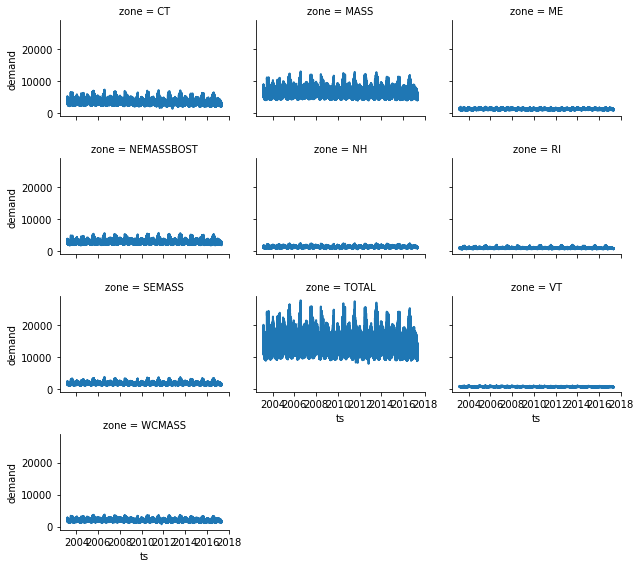

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.relplot(
    data=df,
    x="ts", y="demand", col="zone",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

<AxesSubplot:xlabel='ts', ylabel='demand'>

/Users/ben/time_series/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


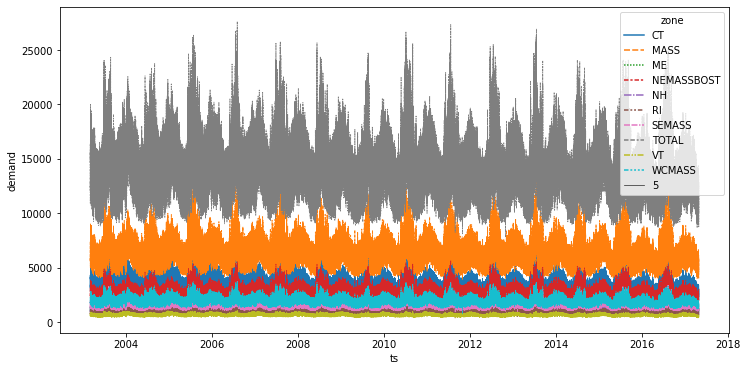

In [33]:
plt.subplots(figsize=[12, 6])
sns.lineplot(
    data=df, x="ts", y="demand", hue="zone", style="zone", size=5,
    estimator=None, color=".7", linewidth=1,
)

In [34]:
dataset = df[
             df["zone"].isin(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS',
                           'VT', 'WCMASS'])
             ]
# TOTAL and MASS are aggregated differently. We won't use these two "zones".

In [60]:
dataset.columns
# The Dry Bulb, Wet Bulb and Dew Point temperatures are important to determine the state of humid air

Index(['ts', 'zone', 'demand', 'drybulb', 'dewpnt', 'date', 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday', 'trend'],
      dtype='object')

<AxesSubplot:>

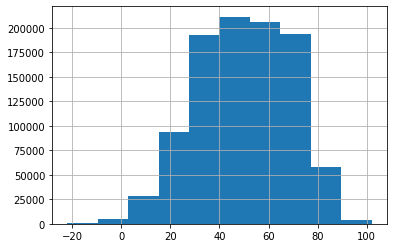

In [61]:
dataset.drybulb.hist()

<AxesSubplot:>

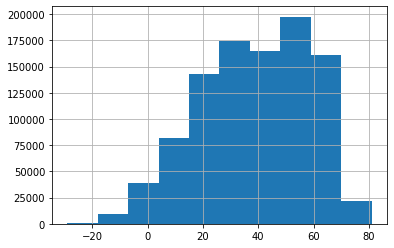

In [62]:
dataset.dewpnt.hist()

In [63]:
import pandas as pd

pivoted = dataset.pivot(index="ts", columns="zone", values="demand")

In [64]:
pivoted.columns

Index(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS'], dtype='object', name='zone')

In [41]:
# we could also add exogenous features like this:
pivoted2 = pivoted.merge(dataset[["ts", 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday']], on=["ts"], how="left").drop_duplicates()

In [68]:
T = len(pivoted.index)
split_t = pivoted.index[T//10 * 8]
split_index = pivoted.index < split_t

In [90]:
train, test = pivoted[split_index], pivoted[~split_index]

In [72]:
train.head()

zone,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,
2003-03-01 00:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0
2003-03-01 01:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0
2003-03-01 02:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0
2003-03-01 03:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0
2003-03-01 04:00:00,3166.0,1077.0,2426.0,1010.0,740.0,1419.0,574.0,1750.0


In [71]:
len(test) / (len(train) + len(test))

0.20000644272817325

## Modeling

In [51]:
!pip install skits

In [15]:
# we can use lagmat to transform a time series into a lagged wide dataset:
import numpy as np
from statsmodels.tsa.tsatools import lagmat

X = np.arange(1,7).reshape(-1,2)
# or: X = np.arange(2,7)
lagmat(X, maxlag=2, trim="forward", original='in')

array([[1., 2., 0., 0., 0., 0.],
       [3., 4., 1., 2., 0., 0.],
       [5., 6., 3., 4., 1., 2.]])

In [73]:
# alternatively, we can use a scikit-learn pipeline with skits
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
# from skits.preprocessing import DifferenceTransformer

from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer
from skits.feature_extraction import (AutoregressiveTransformer, 
                                      SeasonalTransformer)
#dt = DifferenceTransformer(period=4)
#Xt = dt.fit_transform(
#    train[['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']]
#)


pipeline = ForecasterPipeline([
    ("standard", StandardScaler()),                                                              
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [74]:
from sklearn.metrics import mean_squared_error

mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

3831.0479578492736

In [75]:
mean_squared_error(y_pred, test.values, squared=False)

1867.1884583374926

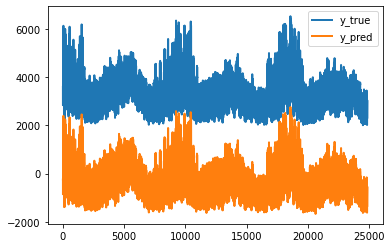

In [76]:
import matplotlib.pyplot as plt

plt.plot(test.values[:, 0], lw=2)
plt.plot(y_pred[:, 0], lw=2)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));

In [78]:
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', DecisionTreeRegressor())
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [79]:
mean_squared_error(y_pred, test.values, squared=False)

114.28075534908372

In [80]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

112.0

In [81]:
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement xgb (from versions: none)
ERROR: No matching distribution found for xgb
Note: you may need to restart the kernel to use updated packages.


In [82]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# other models to try out:
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=0), n_jobs=-1))
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [448]:
mean_squared_error(y_pred, test.values, squared=False)

104.08197535801648

In [449]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

365.1485137939453

In [ ]:
!pip install catboost

In [87]:
from catboost import CatBoostRegressor
#from sklearn.impute import SimpleImputer

pipeline = ForecasterPipeline([
    #("impute", SimpleImputer(strategy="constant", fill_value=-9999)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=4)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    #('regressor', MultiOutputRegressor(CatBoostRegressor(random_state=0), n_jobs=-1))
    ('regressor', CatBoostRegressor(loss_function="MultiRMSE"))
])
pipeline.fit(train.values, train.values)

0:	learn: 1168.0558758	total: 131ms	remaining: 2m 10s
1:	learn: 1138.8358660	total: 421ms	remaining: 3m 30s
2:	learn: 1110.2304935	total: 565ms	remaining: 3m 7s
3:	learn: 1082.6798984	total: 684ms	remaining: 2m 50s
4:	learn: 1055.8654093	total: 766ms	remaining: 2m 32s
5:	learn: 1029.7912059	total: 858ms	remaining: 2m 22s
6:	learn: 1004.8697132	total: 935ms	remaining: 2m 12s
7:	learn: 980.3655862	total: 1.08s	remaining: 2m 14s
8:	learn: 957.1145322	total: 1.17s	remaining: 2m 8s
9:	learn: 934.5239054	total: 1.23s	remaining: 2m 1s
10:	learn: 912.1731184	total: 1.31s	remaining: 1m 57s
11:	learn: 890.8849297	total: 1.41s	remaining: 1m 56s
12:	learn: 870.0645972	total: 1.49s	remaining: 1m 53s
13:	learn: 850.0607295	total: 1.56s	remaining: 1m 49s
14:	learn: 830.5480842	total: 1.64s	remaining: 1m 47s
15:	learn: 811.7930471	total: 1.7s	remaining: 1m 44s
16:	learn: 793.4101739	total: 1.75s	remaining: 1m 41s
17:	learn: 775.9962825	total: 1.81s	remaining: 1m 39s
18:	learn: 759.4228347	total: 1.91s

ForecasterPipeline(steps=[('features',
                           FeatureUnion(transformer_list=[('ar_features',
                                                           AutoregressiveTransformer(num_lags=4))])),
                          ('post_feature_imputer', ReversibleImputer()),
                          ('regressor',
                           <catboost.core.CatBoostRegressor object at 0x7f8f2ff1f160>)])

In [91]:
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)
mean_squared_error(y_pred, test.values, squared=False)

88.79657507562676

In [92]:
MAXLAGS = 4

target_columns = ['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']
colnames = target_columns * MAXLAGS
lagged = pd.DataFrame(data=lagmat(pivoted, maxlag=MAXLAGS, trim="forward", original='ex'), columns=colnames, index=pivoted.index).join(train[[]])
lagged.head()

,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,...,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,,,,,,,,,,,,,,
2003-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 01:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 02:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 03:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,...,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 04:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0,3189.0,1053.0,...,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0


In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor

split_index = lagged.index < split_t
training = lagged[split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = training[[c for c in training.columns if c not in target_columns]], training[[c for c in training.columns if c in target_columns]]

pipeline = make_pipeline(StandardScaler(), CatBoostRegressor(loss_function="MultiRMSE"))
pipeline.fit(X, y)
testing = lagged[~split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = testing[[c for c in testing.columns if c not in target_columns]], testing[[c for c in testing.columns if c in target_columns]]
forecast = pipeline.predict(X)
print(f"MSE all data: {mean_squared_error(y.values, forecast, squared=False)}")
print(f"MSE first point: {mean_squared_error([y.values[0, 0]], [forecast[0, 0]], squared=False)}")

0:	learn: 1167.6276143	total: 1.14s	remaining: 18m 56s
1:	learn: 1137.7566574	total: 2.13s	remaining: 17m 44s
2:	learn: 1108.8696510	total: 2.88s	remaining: 15m 59s
3:	learn: 1080.7095940	total: 3.74s	remaining: 15m 31s
4:	learn: 1053.6525844	total: 4.37s	remaining: 14m 29s
5:	learn: 1027.3317924	total: 5.12s	remaining: 14m 9s
6:	learn: 1001.8117388	total: 5.67s	remaining: 13m 24s
7:	learn: 977.1431968	total: 7.46s	remaining: 15m 25s
8:	learn: 953.5483974	total: 9.1s	remaining: 16m 41s
9:	learn: 930.3806973	total: 10.9s	remaining: 17m 58s
10:	learn: 907.8368348	total: 11.9s	remaining: 17m 47s
11:	learn: 886.1815588	total: 13s	remaining: 17m 49s
12:	learn: 865.1147136	total: 13.7s	remaining: 17m 20s
13:	learn: 844.6734539	total: 14.4s	remaining: 16m 53s
14:	learn: 824.8133956	total: 14.9s	remaining: 16m 20s
15:	learn: 805.8165671	total: 15.7s	remaining: 16m 5s
16:	learn: 786.9838657	total: 16.3s	remaining: 15m 41s
17:	learn: 768.9522987	total: 16.9s	remaining: 15m 24s
18:	learn: 751.780

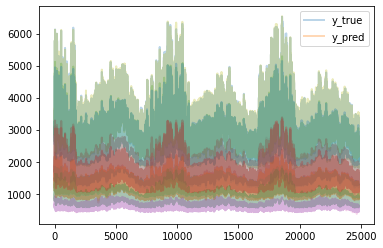

In [94]:
plt.plot(y.values, lw=2, alpha=0.3)
plt.plot(forecast, lw=2, alpha=0.3)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));